In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

class MLP(nn.Module):
    def __init__(self,input,output):
        super().__init__()
        self.layer1 = nn.Linear(input, 16)
        self.layer2 = nn.Linear(16,20)
        self.layer3 = nn.Linear(20,output)

    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

In [2]:
import torch

class DataSet(torch.utils.data.Dataset):
    def __init__(self,data,labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,idx):
        return self.data[idx], self.labels[idx]

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

data = np.genfromtxt('iris.data',delimiter=',')
data = np.delete(data,-1,axis=1)
classes = np.genfromtxt('iris.data',delimiter=',', dtype=str,usecols=[-1])
classes = np.unique(classes,return_inverse=1)[1]

data_treino, data_teste, classe_treino, classe_teste = train_test_split(data,classes,test_size=0.2,stratify=classes,random_state=123)

data_treino, data_validacao, classe_treino, classe_validacao = train_test_split(data_treino,classe_treino,test_size=0.1, stratify=classe_treino, random_state=1)

dataset = DataSet(data_treino,classe_treino)
data_train = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

dataset = DataSet(data_validacao,classe_validacao)
data_val = DataLoader(dataset, batch_size=len(data_validacao), shuffle=True, num_workers=0)

dataset = DataSet(data_teste,classe_teste)
data_test = DataLoader(dataset, batch_size=len(data_teste), shuffle=True, num_workers=0)

In [4]:
mlp = MLP(4,3)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

In [5]:
def train_one_epoch(NeuralNet,Loss,Optimizer,data_treino):
    NeuralNet.train(True)
    current_loss = 0.0
    current_accuracy = 0.0
    total_samples = 0

    for i,data in enumerate(data_treino):
        x,y = data
        x = x.to(torch.float)
        Optimizer.zero_grad()
        output = NeuralNet(x)
        loss = Loss(output,y)
        loss.backward()
        Optimizer.step()
        current_loss += loss.item()
        
        output = output.argmax(dim=1)
        batch_accuracy = torch.eq(output,y)
        batch_accuracy = batch_accuracy.sum()
        current_accuracy += batch_accuracy
        total_samples += len(x)

    return current_loss/(i+1), current_accuracy/total_samples

In [6]:
def validation_one_epoch(NeuralNet,Loss,val_data):
    NeuralNet.train(False)
    current_loss = 0.0
    current_accuracy = 0.0
    total_samples = 0
    for i,data in enumerate(val_data):
        x,y = data
        x = x.to(torch.float)
        output = NeuralNet(x)
        loss = Loss(output,y)
        current_loss += loss.item()

        output = output.argmax(dim=1)
        batch_accuracy = torch.eq(output,y)
        batch_accuracy = batch_accuracy.sum()
        current_accuracy += batch_accuracy
        total_samples += len(x)
    return current_loss/(i+1), current_accuracy/total_samples

In [7]:
epochs = 1000
train_loss_all_epoch = []
train_accuracy_all_epoch = []
val_loss_all_epoch = []
val_accuracy_all_epoch = []
best_val_loss = 1e9

mlp.train(True)
for epoch in range(epochs):
    print(f'Starting epoch {epoch+1}')

    train_loss_per_epoch, train_accuracy_per_epoch = train_one_epoch(mlp,loss_function,optimizer,data_train)

    train_loss_all_epoch.append(train_loss_per_epoch)
    train_accuracy_all_epoch.append(train_accuracy_per_epoch)

    val_loss_per_epoch,val_accuracy_per_epoch = validation_one_epoch(mlp,loss_function,data_train)
    
    val_loss_all_epoch.append(val_loss_per_epoch)
    val_accuracy_all_epoch.append(val_accuracy_per_epoch)

    if val_loss_per_epoch < best_val_loss:
        best_val_loss = val_loss_per_epoch
        model_path = 'SaveModels/test_model'
        torch.save(mlp.state_dict(),model_path)

    print(f'Train Loss: {train_loss_per_epoch}')
    print(f'Val Loss: {val_loss_per_epoch}')
    print(f'Train Accuracy: {train_accuracy_per_epoch}')
    print(f'Val Accuracy: {val_accuracy_per_epoch}')
    print()

print('Training process has finished.')

Starting epoch 1
Train Loss: 1.1259925663471222
Val Loss: 1.1189281940460205
Train Accuracy: 0.3333333432674408
Val Accuracy: 0.3333333432674408

Starting epoch 2
Train Loss: 1.1205540299415588
Val Loss: 1.1216264069080353
Train Accuracy: 0.3333333432674408
Val Accuracy: 0.3333333432674408

Starting epoch 3
Train Loss: 1.1148287653923035
Val Loss: 1.1190283298492432
Train Accuracy: 0.3333333432674408
Val Accuracy: 0.3333333432674408

Starting epoch 4
Train Loss: 1.1258612275123596
Val Loss: 1.1193811893463135
Train Accuracy: 0.3333333432674408
Val Accuracy: 0.3333333432674408

Starting epoch 5
Train Loss: 1.1212528049945831
Val Loss: 1.1182980239391327
Train Accuracy: 0.3333333432674408
Val Accuracy: 0.3333333432674408

Starting epoch 6
Train Loss: 1.1119314432144165
Val Loss: 1.11393404006958
Train Accuracy: 0.3333333432674408
Val Accuracy: 0.3333333432674408

Starting epoch 7
Train Loss: 1.1124712824821472
Val Loss: 1.1015097796916962
Train Accuracy: 0.3333333432674408
Val Accuracy: 

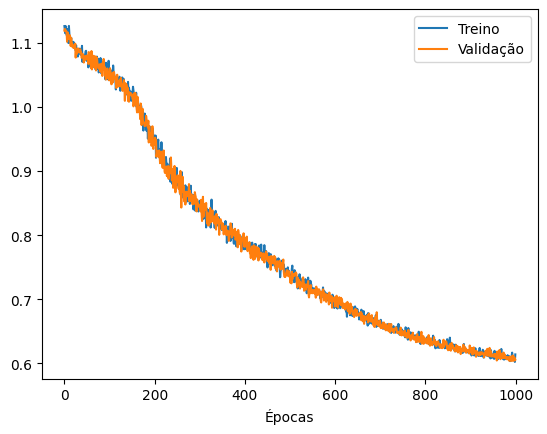

In [8]:
import matplotlib.pyplot as plt

plt.plot(train_loss_all_epoch)
plt.plot(val_loss_all_epoch)
plt.legend(['Treino', 'Validação'])
plt.xlabel('Épocas')

plt.show()

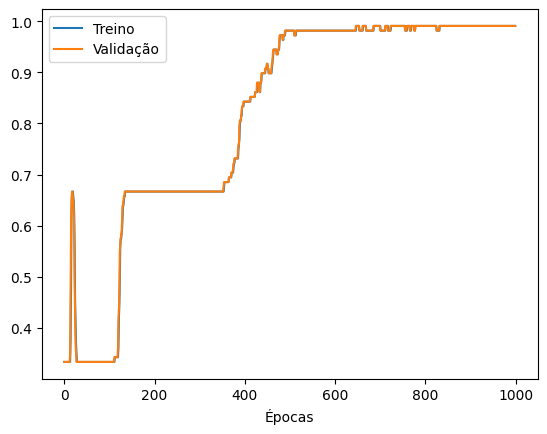

In [9]:
import matplotlib.pyplot as plt

plt.plot(train_accuracy_all_epoch)
plt.plot(val_accuracy_all_epoch)
plt.legend(['Treino', 'Validação'])
plt.xlabel('Épocas')

plt.show()

In [10]:
from sklearn.metrics import classification_report

mlp.train(False)

for data in data_test:
    x_test,y_test = data
    x_test = x_test.to(torch.float32)
    y_pred = mlp(x_test)
    y_pred = torch.Tensor.argmax(y_pred, dim=1)
    
    print(classification_report(y_test,y_pred,zero_division=1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.80      0.89        10
           2       0.83      1.00      0.91        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



In [11]:
saved_model = MLP(4,3)
saved_model.load_state_dict(torch.load('SaveModels/best_model'))

<All keys matched successfully>

In [12]:
from sklearn.metrics import classification_report

saved_model.train(False)

for data in data_test:
    x_test,y_test = data
    x_test = x_test.to(torch.float32)
    y_pred = saved_model(x_test)
    y_pred = torch.Tensor.argmax(y_pred, dim=1)
    
    print(classification_report(y_test,y_pred,zero_division=1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

